#Imports and Mounting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/rul/anshul/
%ls

/gdrive/MyDrive/rul/anshul
charge.csv  discharge_2.csv  discharge.csv  logs/  model.png  SeriesEncoder.h5


#Parameters and Functions

In [ ]:
#PARAMS
BATCH_SIZE = 32
TIME_STEPS = 8
EPOCHS     = 100
SPLIT      = 0.5
SERIES     = 400

In [ ]:
#FUNCTIONS

def create_sequences(xdat,ydat):
  x=[]
  for i in range(TIME_STEPS,len(xdat)+1):
    x.append(xdat[i-TIME_STEPS:i,:])
  return np.stack(x),ydat[TIME_STEPS-1:,:]

def shuffle_data(xdat,ydat):
  idx = np.random.permutation(len(xdat))
  xdat = xdat[idx]
  ydat = ydat[idx]
  return xdat,ydat

def split_data(xdat,ydat,split=SPLIT):
  limit = int(len(xdat)*(1-split))
  return xdat[:limit,:,:],ydat[:limit,:],xdat[limit:,:,:],ydat[limit:,:]

def mish(x):
  return tf.multiply(tf.activations.tanh(tf.activations.softplus(x)),x)



#Data Frame

In [ ]:
y_df = pd.read_csv('discharge_2.csv').drop(['datetime','cycle','ambient_temperature'],axis=1)
y_df['capacity'] = ( y_df['capacity'] - y_df['capacity'].min()  ) / ( y_df['capacity'].max() - y_df['capacity'].min() )
y_df

,capacity
0,1.000000
1,0.982145
2,0.962852
3,0.962700
4,0.961616
...,...
163,0.010564
164,0.000968
165,0.000000
166,0.037894


In [ ]:
cycle_df = pd.read_csv('discharge.csv').drop(['datetime','time','capacity','ambient_temperature'],axis=1)

for col in ( ['voltage_measured',	'current_measured',	'temperature_measured',	'current_load',	'voltage_load' ] ):
  #cycle_df[col] = ( cycle_df[col] - cycle_df[col].mean() ) /  cycle_df[col].std()
  cycle_df[col] = ( cycle_df[col] - cycle_df[col].min()  ) / ( cycle_df[col].max() - cycle_df[col].min() )
#cycle_df = cycle_df.drop(['current_measured','current_load',	'voltage_load'],axis=1)
cycle_df = cycle_df.drop(['current_load',	'voltage_load'],axis=1)
cycle_df['cycle'] = cycle_df['cycle'] - 1
cycle_df

,cycle,voltage_measured,current_measured,temperature_measured
0,0,0.982216,0.993912,0.061157
1,0,0.981796,0.995594,0.060936
2,0,0.859640,0.008136,0.064396
3,0,0.846539,0.007424,0.072932
4,0,0.836713,0.008816,0.083167
...,...,...,...,...
50280,167,0.635784,0.995549,0.638867
50281,167,0.637313,0.994813,0.636123
50282,167,0.638738,0.994807,0.628527
50283,167,0.640352,0.996918,0.622457


#AutoFeature

In [ ]:
latent_features = 8
FEATURES        = 5
act             ='swish'

In [ ]:
inp = keras.layers.Input((400,FEATURES))

conv = keras.layers.Conv1D(8,3,activation=act)(inp)
conv = keras.layers.Conv1D(8,3,activation=act)(conv)
conv = keras.layers.Conv1D(8,3,activation=act)(conv)

conv = keras.layers.MaxPooling1D(2)(conv)

conv = keras.layers.Conv1D(16,4,activation=act)(conv)
conv = keras.layers.Conv1D(16,3,activation=act)(conv)
conv = keras.layers.Conv1D(16,3,activation=act)(conv)

conv = keras.layers.MaxPooling1D(2)(conv)

conv = keras.layers.Conv1D(32,4,activation=act)(conv)
conv = keras.layers.Conv1D(32,3,activation=act)(conv)
conv = keras.layers.Conv1D(32,3,activation=act)(conv)

conv = keras.layers.MaxPooling1D(2)(conv)

conv = keras.layers.Conv1D(64,3,activation=act)(conv)
conv = keras.layers.Conv1D(64,3,activation=act)(conv)
conv = keras.layers.Conv1D(64,3,activation=act)(conv)

conv = keras.layers.MaxPooling1D(2)(conv)

conv = keras.layers.Conv1D(128,3,activation=act)(conv)
conv = keras.layers.Conv1D(128,3,activation=act)(conv)
conv = keras.layers.Conv1D(128,3,activation=act)(conv)

gap = keras.layers.GlobalMaxPooling1D()(conv)

out = keras.layers.Dense(latent_features)(gap)

SeriesEncoder = keras.models.Model(inputs=inp,outputs=out)
SeriesEncoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 5)]          0         
                                                                 
 conv1d (Conv1D)             (None, 398, 8)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 396, 8)            200       
                                                                 
 conv1d_2 (Conv1D)           (None, 394, 8)            200       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 197, 8)           0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 194, 16)           528       
                                                             

In [ ]:
SeriesEncoder.load_weights('SeriesEncoder.h5')

In [ ]:
exinp_df = pd.read_csv('discharge.csv').drop(['datetime','time','capacity','ambient_temperature'],axis=1)

for col in ( ['voltage_measured',	'current_measured',	'temperature_measured',	'current_load',	'voltage_load' ] ):
  #cycle_df[col] = ( cycle_df[col] - cycle_df[col].mean() ) /  cycle_df[col].std()
  exinp_df[col] = ( exinp_df[col] - exinp_df[col].min()  ) / ( exinp_df[col].max() - exinp_df[col].min() )
#cycle_df = cycle_df.drop(['current_measured','current_load',	'voltage_load'],axis=1)
#exinp_df = exinp_df.drop(['current_measured','current_load',	'voltage_load'],axis=1)
exinp_df['cycle'] = exinp_df['cycle'] - 1
exinp_df

,cycle,voltage_measured,current_measured,temperature_measured,current_load,voltage_load
0,0,0.982216,0.993912,0.061157,0.49985,0.000000
1,0,0.981796,0.995594,0.060936,0.49985,0.992449
2,0,0.859640,0.008136,0.064396,0.00005,0.722511
3,0,0.846539,0.007424,0.072932,0.00005,0.714960
4,0,0.836713,0.008816,0.083167,0.00005,0.710477
...,...,...,...,...,...,...
50280,167,0.635784,0.995549,0.638867,0.50015,0.000000
50281,167,0.637313,0.994813,0.636123,0.50015,0.000000
50282,167,0.638738,0.994807,0.628527,0.50015,0.000000
50283,167,0.640352,0.996918,0.622457,0.50015,0.000000


In [ ]:
pre_x_dat = []
for i in range(0,168):
  temp = exinp_df.loc[cycle_df['cycle'] == i]
  temp = temp.to_numpy()[:,1:]
  temp = np.vstack( [ temp, np.zeros((SERIES-temp.shape[0],temp.shape[1])) ] )
  pre_x_dat.append(temp)


print(min(pre_x_dat, key = lambda k: len(k)).shape)
print(max(pre_x_dat, key = lambda k: len(k)).shape)
pre_x_dat = np.array(pre_x_dat)
pre_x_dat.shape

(400, 5)
(400, 5)


(168, 400, 5)

In [ ]:
extracted_x_dat = SeriesEncoder(pre_x_dat,training=False)
extracted_x_dat = pd.DataFrame(extracted_x_dat.numpy())
extracted_x_dat = ( extracted_x_dat - extracted_x_dat.min() ) / ( extracted_x_dat.max() - extracted_x_dat.min() + 10e-10 )
extracted_x_dat

,0,1,2,3,4,5,6,7
0,0.504445,0.182553,0.496818,0.990630,0.574680,0.000869,0.695262,0.963226
1,0.510201,0.174979,0.511114,1.000000,0.581231,0.000000,0.693646,0.967241
2,0.505634,0.183862,0.510928,0.997723,0.576532,0.010657,0.698062,0.967167
3,0.489925,0.201525,0.503112,0.993817,0.562008,0.026864,0.709533,0.967782
4,0.484578,0.210470,0.490641,0.985348,0.555736,0.030489,0.711148,0.964646
...,...,...,...,...,...,...,...,...
163,0.970141,0.026011,0.946217,0.413449,0.981013,0.069793,0.028611,0.051267
164,0.992837,0.005329,0.986627,0.402636,0.994603,0.084829,0.009306,0.027170
165,1.000000,0.000000,1.000000,0.399656,1.000000,0.089870,0.002692,0.020450
166,0.958347,0.057312,0.945819,0.421168,0.990702,0.107760,0.025109,0.060242


#Data Preprocess

In [ ]:
x_dat = extracted_x_dat.to_numpy()
#x_dat = pd.concat([extracted_x_dat, cycle_df.groupby('cycle').mean()], axis=1).to_numpy()
#x_dat = cycle_df.groupby('cycle').mean().to_numpy()

y_dat = y_df.to_numpy()
print(x_dat.shape,y_dat.shape)
x_dat, y_dat = create_sequences(x_dat,y_dat)
x_train, y_train, x_test, y_test = split_data(x_dat,y_dat)
x_eval = x_dat
y_eval = y_dat
print(x_dat.shape,y_dat.shape)
print([each.shape for each in [x_train, y_train, x_test, y_test]])

(168, 8) (168, 1)
(161, 8, 8) (161, 1)
[(80, 8, 8), (80, 1), (81, 8, 8), (81, 1)]


#Toy Model

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8, 16)]           0         
                                                                 
 gaussian_noise_18 (Gaussian  (None, 8, 16)            0         
 Noise)                                                          
                                                                 
 batch_normalization_3 (Batc  (None, 8, 16)            64        
 hNormalization)                                                 
                                                                 
 conv1d_30 (Conv1D)          (None, 8, 32)             2592      
                                                                 
 activation_15 (Activation)  (None, 8, 32)             0         
                                                                 
 dropout_18 (Dropout)        (None, 8, 32)             0   

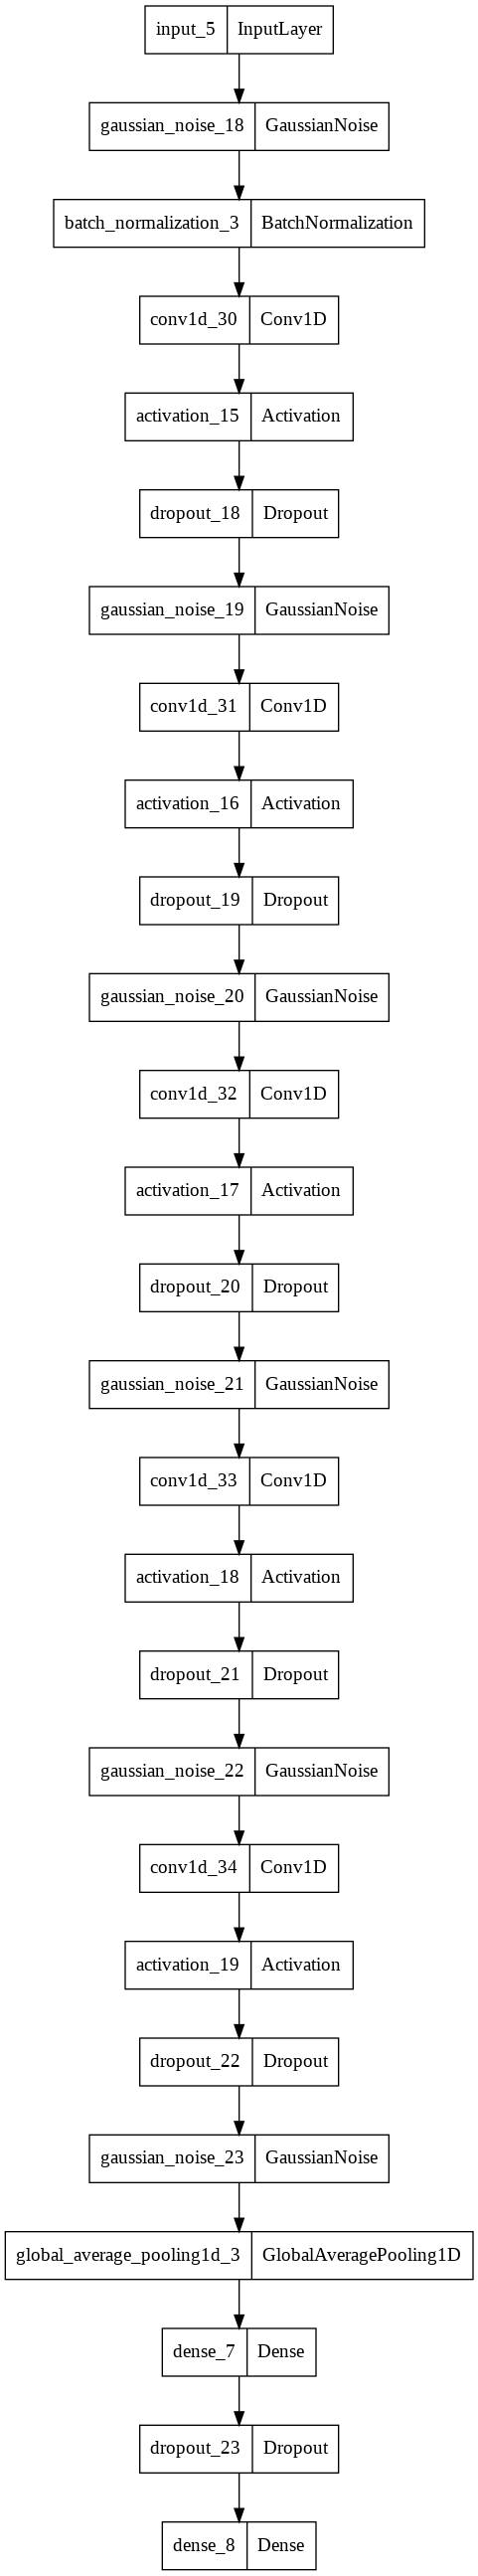

In [ ]:
#MODEL
act = 'swish'
kr  = keras.regularizers.l2(10e-5)

inp  = keras.layers.Input(x_train[0].shape)
pre  = keras.layers.GaussianNoise(0.3)(inp)
conv = keras.layers.BatchNormalization()(pre)
conv = keras.layers.Conv1D(32,5,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.2)(conv)
conv  = keras.layers.GaussianNoise(0.3)(conv)


conv = keras.layers.Conv1D(64,3,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.3)(conv)
conv  = keras.layers.GaussianNoise(0.3)(conv)

conv = keras.layers.Conv1D(64,3,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.3)(conv)
conv  = keras.layers.GaussianNoise(0.3)(conv)


conv = keras.layers.Conv1D(128,3,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.2)(conv)
conv  = keras.layers.GaussianNoise(0.2)(conv)

conv = keras.layers.Conv1D(128,3,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.3)(conv)
conv  = keras.layers.GaussianNoise(0.2)(conv)

gap = keras.layers.GlobalAveragePooling1D()(conv)

dense = keras.layers.Dense(32,activation=act,kernel_regularizer=kr)(gap)
dense = keras.layers.Dropout(0.3)(dense)

out = keras.layers.Dense(1)(dense)


model = keras.models.Model(inputs=inp,outputs=out)
model.summary()
keras.utils.plot_model(model)

#Train

In [ ]:
#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Adam( learning_rate = 0.001, decay = 10e-5 )
metrics = [
           'mae',
           'mape',
]

model.compile(loss = loss,optimizer=optimizer,metrics=metrics)

NameError: ignored

In [ ]:
#RUN

hist = model.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*1,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                 )

Epoch 1/100
3/3 [==============================] - 2s 147ms/step - loss: 0.3277 - mae: 0.7422 - mape: 97.0694 - val_loss: 0.0653 - val_mae: 0.1759 - val_mape: 519693.2500
Epoch 2/100
3/3 [==============================] - 0s 26ms/step - loss: 0.3261 - mae: 0.7352 - mape: 95.5395 - val_loss: 0.0643 - val_mae: 0.1712 - val_mape: 621840.4375
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 0.3267 - mae: 0.7396 - mape: 97.3172 - val_loss: 0.0634 - val_mae: 0.1666 - val_mape: 736555.5625
Epoch 4/100
3/3 [==============================] - 0s 25ms/step - loss: 0.2961 - mae: 0.6947 - mape: 90.3110 - val_loss: 0.0625 - val_mae: 0.1630 - val_mape: 860130.9375
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.2791 - mae: 0.6708 - mape: 87.5698 - val_loss: 0.0617 - val_mae: 0.1601 - val_mape: 997081.3125
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 0.2658 - mae: 0.6509 - mape: 84.6717 - val_loss: 0.0609 - val_mae: 0.1577 - v

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


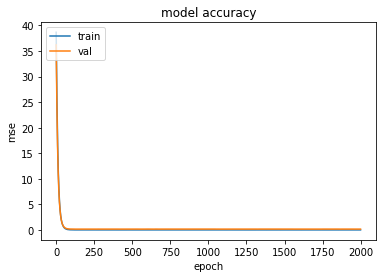

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

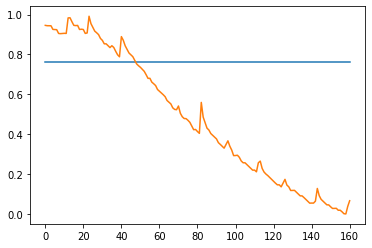

In [ ]:
plt.plot(model.predict(x_eval))
plt.plot(y_eval)
plt.show()

#ResNet-50

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 8, 16)]      0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 8, 16)        272         ['input_7[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 8, 16)        64          ['conv1[0][0]']                  
                                                                                                  
 activation_25 (Activation)     (None, 8, 16)        0           ['bn_conv1[0][0]']               
                                                                                           

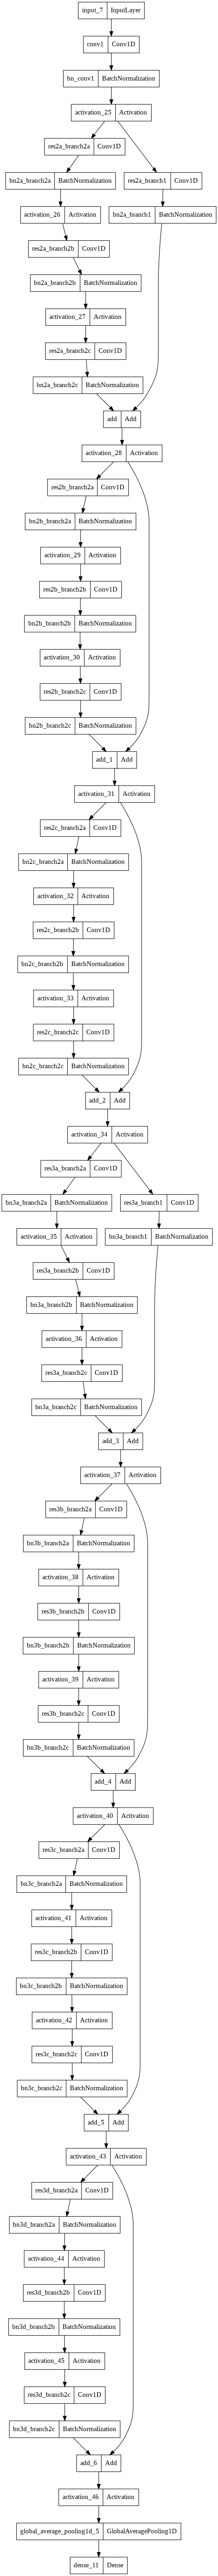

In [ ]:
kr = keras.regularizers.l2(0.001)
act = 'swish'

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = keras.layers.Conv1D(filters=F1, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2a', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])# SKIP Connection
    X = keras.layers.Activation(act)(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv1D(filters=F1, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '2a', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv1D(filters=F3, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '1', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation(act)(X)

    return X


def ResNet50(input_shape=x_train[0].shape):

    X_input = keras.layers.Input(input_shape)

    X = keras.layers.Conv1D(16, 1, strides=1, name='conv1', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X_input)
    X = keras.layers.BatchNormalization(axis=2, name='bn_conv1')(X)
    X = keras.layers.Activation(act)(X)

    X = convolutional_block(X, f=3, filters=[32, 32, 64], stage=2, block='a', s=1)
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[64, 64, 128], stage=3, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='d')


    X = keras.layers.GlobalAveragePooling1D()(X)
    out = keras.layers.Dense(1)(X)
    
    model = keras.models.Model(inputs=X_input, outputs=out, name='ResNet50')

    return model

model = ResNet50()
model.summary()
keras.utils.plot_model(model)

In [ ]:
#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Adam( learning_rate = 0.001, decay = 10e-5 )
metrics = [
           'mae',
           'mape',
]

model.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:
#RUN

hist = model.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*10,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                 )

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_eval = x_df.to_numpy()
y_eval = y_df.to_numpy()

x_eval = ( x_eval - np.amin(x_eval,axis=0) ) / ( np.amax(x_eval,axis=0) - np.amin(x_eval,axis=0) + 10e-10)
y_eval = ( y_eval - np.amin(y_eval,axis=0) ) / ( np.amax(y_eval,axis=0) - np.amin(y_eval,axis=0) + 10e-10)

x_eval, y_eval = create_sequences(x_eval,y_eval)


In [ ]:
plt.plot(model.predict(x_eval))
plt.plot(y_eval)
plt.show()

#The Neuron

In [ ]:
kr  = keras.regularizers.L2(0.0001)
kr2 = keras.regularizers.L2(0.0001)
kr3 = keras.regularizers.L2(0.0005)
act = None

inp  = keras.layers.Input(x_train[0].shape)
flat = keras.layers.Flatten()(inp)
dense = keras.layers.Dense(32,activation=act,kernel_regularizer=kr3)(dense)
dense = keras.layers.Dense(16,kernel_regularizer=kr2)(dense)
dense = keras.layers.Dense(4,kernel_regularizer=kr)(dense)
out  = keras.layers.Dense(1)(flat)

TheNeuron = keras.models.Model(inputs=inp,outputs=out)
TheNeuron.summary()

Model: "model_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 8, 8)]            0         
                                                                 
 flatten_69 (Flatten)        (None, 64)                0         
                                                                 
 dense_100 (Dense)           (None, 1)                 65        
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [ ]:

#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Nadam( learning_rate = 0.001, decay=10e-6 )
metrics = [
           'mae',
           'mape',
]

TheNeuron.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:
#RUN
callbacks=[
           #keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7,patience=5, min_lr=0.0001),
           keras.callbacks.EarlyStopping(monitor='val_mae', patience=1000, restore_best_weights=True)
]

hist = TheNeuron.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*50,
                  validation_data = ( x_test , y_test ),
                  callbacks=callbacks
                 )

Epoch 1/5000
3/3 [==============================] - 1s 87ms/step - loss: 0.2287 - mae: 0.5652 - mape: 74.0918 - val_loss: 0.9282 - val_mae: 1.4209 - val_mape: 24094130.0000
Epoch 2/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.1876 - mae: 0.4918 - mape: 64.0663 - val_loss: 0.8659 - val_mae: 1.3546 - val_mape: 23303100.0000
Epoch 3/5000
3/3 [==============================] - 0s 25ms/step - loss: 0.1532 - mae: 0.4257 - mape: 55.0487 - val_loss: 0.8031 - val_mae: 1.2863 - val_mape: 22482752.0000
Epoch 4/5000
3/3 [==============================] - 0s 27ms/step - loss: 0.1239 - mae: 0.3686 - mape: 47.0747 - val_loss: 0.7441 - val_mae: 1.2208 - val_mape: 21676488.0000
Epoch 5/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.0997 - mae: 0.3264 - mape: 40.8680 - val_loss: 0.6880 - val_mae: 1.1570 - val_mape: 20879838.0000
Epoch 6/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.0814 - mae: 0.3000 - mape: 37.0598 - val_loss: 0.6375 - val_

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


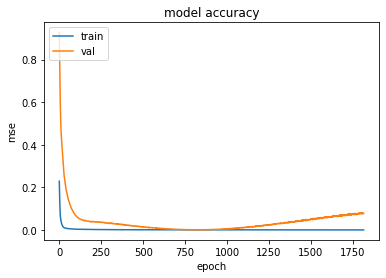

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_eval = x_dat
y_eval = y_dat


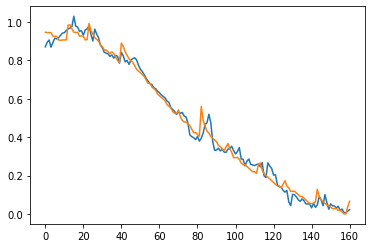

In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()

#ANN

In [ ]:
#kr = keras.regularizers.l2(0.00001)
act = 'tanh'

inp  = keras.layers.Input(x_train[0].shape)
flat = keras.layers.Flatten()(inp)
dense  = keras.layers.Dense(16,activation=act,kernel_regularizer=kr)(flat)
out  = keras.layers.Dense(1)(dense)

TheNeuron = keras.models.Model(inputs=inp,outputs=out)
TheNeuron.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 8, 10)]           0         
                                                                 
 flatten_8 (Flatten)         (None, 80)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                1296      
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#COMPILE

loss = [
        'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        #tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Adam( learning_rate = 0.001)

metrics = [
           'mae',
           'mape',
]

TheNeuron.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:
#RUN
callbacks=[
           keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7,patience=5, min_lr=0.00001),
           keras.callbacks.EarlyStopping(monitor='loss', patience=50)
]
hist = TheNeuron.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*20,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                  callbacks=callbacks
                 )

Epoch 1/2000
3/3 [==============================] - 0s 74ms/step - loss: 0.0231 - mae: 0.1123 - mape: 15.6765 - val_loss: 0.1852 - val_mae: 0.4127 - val_mape: 7169141.5000 - lr: 0.0010
Epoch 2/2000
3/3 [==============================] - 0s 15ms/step - loss: 0.0224 - mae: 0.1103 - mape: 15.6980 - val_loss: 0.2043 - val_mae: 0.4353 - val_mape: 7442447.0000 - lr: 0.0010
Epoch 3/2000
3/3 [==============================] - 0s 15ms/step - loss: 0.0223 - mae: 0.1065 - mape: 15.4964 - val_loss: 0.2010 - val_mae: 0.4315 - val_mape: 7391277.0000 - lr: 0.0010
Epoch 4/2000
3/3 [==============================] - 0s 15ms/step - loss: 0.0220 - mae: 0.1064 - mape: 15.3616 - val_loss: 0.1900 - val_mae: 0.4186 - val_mape: 7229067.0000 - lr: 0.0010
Epoch 5/2000
3/3 [==============================] - 0s 15ms/step - loss: 0.0219 - mae: 0.1075 - mape: 15.2198 - val_loss: 0.1820 - val_mae: 0.4090 - val_mape: 7108662.5000 - lr: 0.0010
Epoch 6/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape', 'lr'])


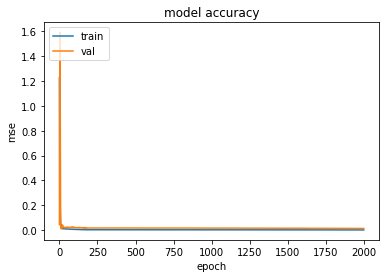

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

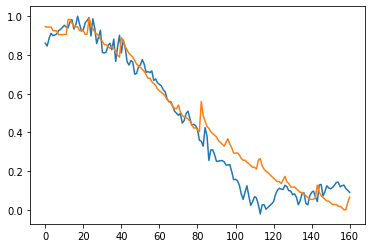

In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()
#NotShuffled

#ANN 2

In [ ]:
act  =  'tanh'
kr = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)

inp    = keras.layers.Input(x_train[0].shape)
flat   = keras.layers.Flatten()(inp)
#flat  = keras.layers.LayerNormalization()(flat)
flat  = keras.layers.Dropout(0.1)(flat)
dense  = keras.layers.Dense(64,activation=act,kernel_regularizer=kr)(flat)
#dense  = keras.layers.LayerNormalization()(dense)
dense  = keras.layers.Dense(16,activation=act,kernel_regularizer=kr)(dense)
out    = keras.layers.Dense(1)(dense)

TheNeuron = keras.models.Model(inputs=inp,outputs=out)
TheNeuron.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 8, 16)]           0         
                                                                 
 flatten_17 (Flatten)        (None, 128)               0         
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_51 (Dense)            (None, 64)                8256      
                                                                 
 dense_52 (Dense)            (None, 16)                1040      
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 9,313
Trainable params: 9,313
Non-trainable 

In [ ]:
#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Adam( learning_rate = 0.0001 )
metrics = [
           'mae',
           'mape',
]
TheNeuron.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:

#RUN

callbacks=[
           keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7,patience=25,cooldown=50, min_lr=0.00007),
           keras.callbacks.EarlyStopping(monitor='loss', patience=1000, restore_best_weights=True)
]

hist = TheNeuron.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*50,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                  callbacks=callbacks
                 )

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()
#NotShuffled

#Correlation Test

In [ ]:
cor = pd.concat([extracted_x_dat, y_df], axis=1)
cor.corr()

,0,1,2,3,4,5,6,7,capacity
0,1.000000,-0.925471,0.933342,0.072273,0.992255,-0.546576,-0.922017,-0.653457,-0.790299
1,-0.925471,1.000000,-0.881363,-0.428353,-0.924669,0.773066,0.717842,0.343964,0.508874
2,0.933342,-0.881363,1.000000,0.138222,0.943067,-0.438507,-0.882110,-0.672921,-0.755659
3,0.072273,-0.428353,0.138222,1.000000,0.118603,-0.692619,0.245389,0.562592,0.470925
4,0.992255,-0.924669,0.943067,0.118603,1.000000,-0.556483,-0.923385,-0.658778,-0.790058
5,-0.546576,0.773066,-0.438507,-0.692619,-0.556483,1.000000,0.220483,-0.230568,-0.008811
6,-0.922017,0.717842,-0.882110,0.245389,-0.923385,0.220483,1.000000,0.892154,0.960501
7,-0.653457,0.343964,-0.672921,0.562592,-0.658778,-0.230568,0.892154,1.000000,0.964912
capacity,-0.790299,0.508874,-0.755659,0.470925,-0.790058,-0.008811,0.960501,0.964912,1.000000


In [ ]:
cor = pd.concat([cycle_df, y_df], axis=1)
cor.corr()

,cycle,voltage_measured,current_measured,temperature_measured,capacity
cycle,1.000000,-0.132877,0.127769,0.139936,NaN
voltage_measured,-0.132877,1.000000,-0.091667,-0.914580,0.940539
current_measured,0.127769,-0.091667,1.000000,0.354628,0.160740
temperature_measured,0.139936,-0.914580,0.354628,1.000000,-0.942558
capacity,NaN,0.940539,0.160740,-0.942558,1.000000


In [ ]:
cor = pd.concat([extracted_x_dat,cycle_df, y_df], axis=1)
cor.corr()

,0,1,2,3,4,5,6,7,cycle,voltage_measured,current_measured,temperature_measured,capacity
0,1.000000,-0.925471,0.933342,0.072273,0.992255,-0.546576,-0.922017,-0.653457,NaN,-0.618766,0.012146,0.616129,-0.790299
1,-0.925471,1.000000,-0.881363,-0.428353,-0.924669,0.773066,0.717842,0.343964,NaN,0.302669,-0.106457,-0.291808,0.508874
2,0.933342,-0.881363,1.000000,0.138222,0.943067,-0.438507,-0.882110,-0.672921,NaN,-0.585610,-0.013564,0.566198,-0.755659
3,0.072273,-0.428353,0.138222,1.000000,0.118603,-0.692619,0.245389,0.562592,NaN,0.613056,0.242002,-0.644094,0.470925
4,0.992255,-0.924669,0.943067,0.118603,1.000000,-0.556483,-0.923385,-0.658778,NaN,-0.613555,0.020810,0.607971,-0.790058
5,-0.546576,0.773066,-0.438507,-0.692619,-0.556483,1.000000,0.220483,-0.230568,NaN,-0.155062,-0.186192,0.150569,-0.008811
6,-0.922017,0.717842,-0.882110,0.245389,-0.923385,0.220483,1.000000,0.892154,NaN,0.834975,0.067888,-0.834382,0.960501
7,-0.653457,0.343964,-0.672921,0.562592,-0.658778,-0.230568,0.892154,1.000000,NaN,0.914529,0.155888,-0.912812,0.964912
cycle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.132877,0.127769,0.139936,NaN
voltage_measured,-0.618766,0.302669,-0.585610,0.613056,-0.613555,-0.155062,0.834975,0.914529,-0.132877,1.000000,-0.091667,-0.914580,0.940539


In [ ]:
print(extracted_x_dat.head(0))
extracted_x_dat = extracted_x_dat.drop([1,2,3,4,5,6,7],axis=1)
extracted_x_dat

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7]
Index: []


,0,4,5,6,7
0,0.275133,0.747646,0.314175,0.245698,0.340488
1,0.289345,0.738190,0.320916,0.256434,0.352617
2,0.261883,0.772384,0.288718,0.226329,0.319395
3,0.239798,0.797025,0.267178,0.204089,0.296069
4,0.219478,0.816973,0.249934,0.186153,0.276787
...,...,...,...,...,...
163,0.918829,0.099535,0.864556,0.860930,0.933155
164,0.918897,0.099317,0.862864,0.861459,0.931930
165,0.937217,0.081445,0.878269,0.877226,0.948846
166,0.945762,0.071879,0.892192,0.884267,0.957014


#Mods

Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 8, 8)]            0         
                                                                 
 locally_connected1d_64 (Loc  (None, 6, 4)             600       
 allyConnected1D)                                                
                                                                 
 locally_connected1d_65 (Loc  (None, 4, 4)             208       
 allyConnected1D)                                                
                                                                 
 flatten_48 (Flatten)        (None, 16)                0         
                                                                 
 dense_49 (Dense)            (None, 1)                 17        
                                                                 
Total params: 825
Trainable params: 825
Non-trainable para

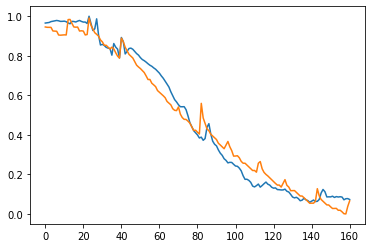

In [ ]:


kr = keras.regularizers.L1(0.0001)
act = 'tanh'

inp  = keras.layers.Input(x_train[0].shape)
conv = keras.layers.LocallyConnected1D(4,3,activation=act,kernel_regularizer=kr)(inp)
conv = keras.layers.LocallyConnected1D(4,3,activation=act,kernel_regularizer=kr)(conv)
flat = keras.layers.Flatten()(conv)
out  = keras.layers.Dense(1)(flat)

TheNeuron = keras.models.Model(inputs=inp,outputs=out)
TheNeuron.summary()



#COMPILE

loss = [
        'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        #tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Nadam( learning_rate = 0.01, decay=10e-5 )
metrics = [
           'mae',
           'mape',
]

TheNeuron.compile(loss = loss,optimizer=optimizer,metrics=metrics)



#RUN
callbacks=[
           #keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7,patience=5, min_lr=0.0001),
           keras.callbacks.EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)
]

hist = TheNeuron.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*10,
                  validation_data = ( x_test , y_test ),
                  callbacks=callbacks
                 )



plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()

In [ ]:
kr  = keras.regularizers.L2(0.0001)
kr2 = keras.regularizers.L2(0.0001)
kr3 = keras.regularizers.L2(0.0005)
act = None

inp  = keras.layers.Input(x_train[0].shape)
flat = keras.layers.Flatten()(inp)
dense = keras.layers.Dense(32,activation=act,kernel_regularizer=kr3)(dense)
dense = keras.layers.Dense(16,kernel_regularizer=kr2)(dense)
dense = keras.layers.Dense(4,kernel_regularizer=kr)(dense)
out  = keras.layers.Dense(1)(flat)

TheNeuron = keras.models.Model(inputs=inp,outputs=out)
TheNeuron.summary()



#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Nadam( learning_rate = 0.001, decay=10e-6 )
metrics = [
           'mae',
           'mape',
]

TheNeuron.compile(loss = loss,optimizer=optimizer,metrics=metrics)




#RUN
callbacks=[
           #keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7,patience=5, min_lr=0.0001),
           keras.callbacks.EarlyStopping(monitor='val_mae', patience=1000, restore_best_weights=True)
]

hist = TheNeuron.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*50,
                  validation_data = ( x_test , y_test ),
                  callbacks=callbacks
                 )




plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()
